In [1]:
import os 
import numpy as np
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from tqdm.keras import TqdmCallback
%matplotlib inline

# What is ResNet 50
ResNet50 is a convolutional neural network (CNN) architecture that was introduced by Microsoft Research in 2015. It is a deep neural network that has 50 layers, and it achieved state-of-the-art results in image classification and object detection tasks on the ImageNet dataset. The name "ResNet" stands for "Residual Network", which refers to the use of residual connections between layers to overcome the vanishing gradient problem that can occur in deep neural networks.

The architecture of ResNet50 is based on the idea of residual learning, which involves adding skip connections between layers to allow the network to learn residual functions. These residual functions capture the difference between the input and output of a layer, making it easier for the network to learn the underlying mapping between input and output.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*tH9evuOFqk8F41FG.png)

ResNet50 consists of multiple blocks of layers, each of which contains convolutional layers, batch normalization layers, and activation functions. The first block of layers performs convolution and pooling operations to extract low-level features from the input image, while subsequent blocks of layers progressively extract higher-level features. The skip connections between layers allow information to be passed directly from one layer to another, bypassing intermediate layers and improving the flow of information through the network.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rPktw9-nz-dy9CFcddMBdQ.jpeg)

ResNet50 has been widely used in various computer vision tasks, including object recognition, object detection, and image segmentation. Its success has led to the development of even deeper ResNet architectures, such as ResNet101 and ResNet152, which have been shown to achieve even better performance on challenging visual recognition tasks.

In [2]:
!ls /kaggle/input/brain-tumor-mri-images-17-classes

'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1'
'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+'
'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2'
'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1'
'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+'
'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2'
'NORMAL T1'
'NORMAL T2'
'Neurocitoma (Central - Intraventricular, Extraventricular) T1'
'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+'
'Neurocitoma (Central - Intraventricular, Extraventricular) T2'
'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1'
'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+'
'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2'
'Schwannoma (Acustico, Vestibular - Trigeminal) T1'
'Schwannoma (Acustico, Vestibular - Trigeminal

In [3]:
class_size = len(os.listdir('/kaggle/input/brain-tumor-mri-images-17-classes'))
dataset_dir="/kaggle/input/brain-tumor-mri-images-17-classes"
TARGET_SIZE=(224,224)
BATCH_SIZE=16

In [4]:
data_gen=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.20)

In [5]:
train_cap=data_gen.flow_from_directory(
    dataset_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
valid_cap=data_gen.flow_from_directory(
    dataset_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 3539 images belonging to 17 classes.
Found 876 images belonging to 17 classes.


In [6]:
model=Sequential()
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
))
model.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(44,activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(class_size,activation='softmax'))
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
red_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_lr=0.00000001)


94765736/94765736 [==============================] - 4s 0us/step


In [7]:
history=model.fit(
    train_cap,
    steps_per_epoch=len(train_cap),
    epochs=50,
    validation_data=valid_cap,
    validation_steps=len(valid_cap),
    verbose=0,
    callbacks=[red_lr,TqdmCallback(verbose=0)]
    )


0epoch [00:00, ?epoch/s]

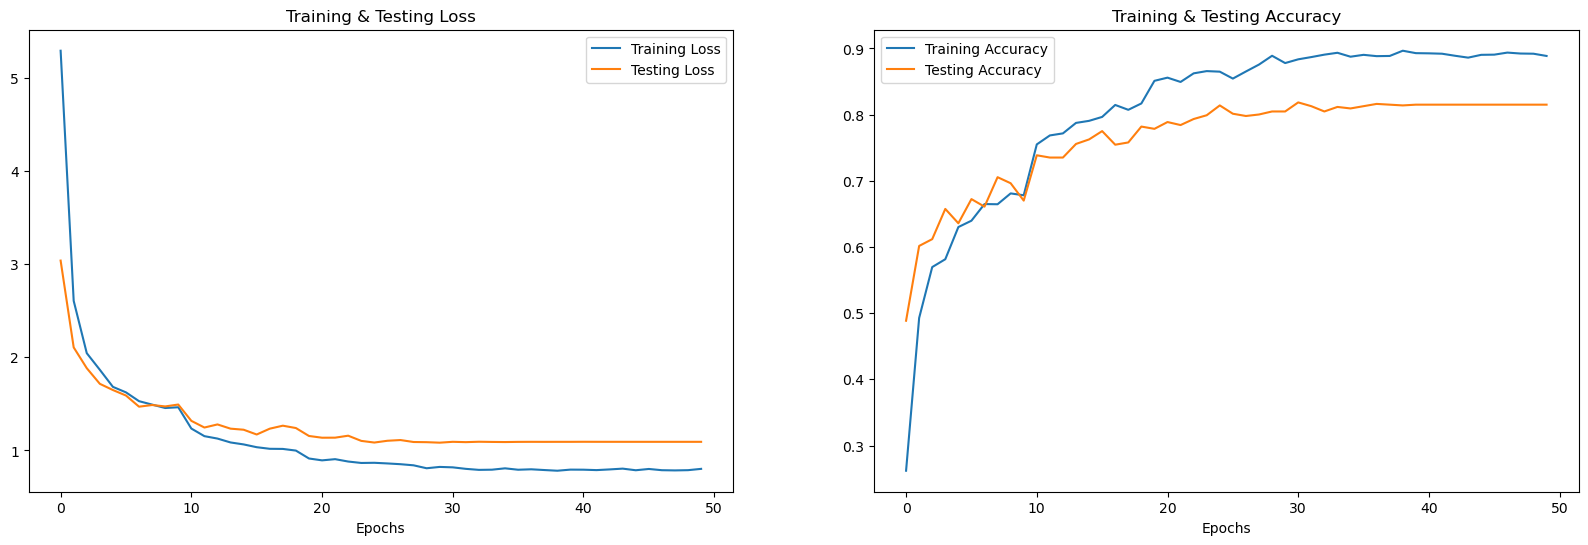

In [8]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()